# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment

from tqdm.notebook import tqdm
tqdm.pandas()


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/train.csv').drop_duplicates()
test = pd.read_csv('../Dataset/test.csv')

data = data.drop(columns=['User_ID', 'Product_ID'])
data = data.drop_duplicates().dropna()
data

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
6,M,46-50,7,B,2,1,1,8.0,17.0,19215
13,M,26-35,20,A,1,1,1,2.0,5.0,15665
14,F,51-55,9,A,1,0,5,8.0,14.0,5378
16,F,51-55,9,A,1,0,2,3.0,4.0,13055
...,...,...,...,...,...,...,...,...,...,...
545902,F,46-50,0,B,4+,1,3,4.0,12.0,8047
545904,M,26-35,6,B,2,0,6,8.0,14.0,16493
545907,M,26-35,6,B,2,0,2,3.0,10.0,3425
545908,M,26-35,6,B,2,0,1,2.0,15.0,15694


# 3. Initial Analysis

### 3.1. Metadata

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166610 entries, 1 to 545914
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Gender                      166610 non-null  int8 
 1   Age                         166610 non-null  int8 
 2   Occupation                  166610 non-null  int8 
 3   City_Category               166610 non-null  int8 
 4   Stay_In_Current_City_Years  166610 non-null  int8 
 5   Marital_Status              166610 non-null  int8 
 6   Product_Category_1          166610 non-null  int8 
 7   Product_Category_2          166610 non-null  int8 
 8   Product_Category_3          166610 non-null  int8 
 9   Purchase                    166610 non-null  int64
dtypes: int64(1), int8(9)
memory usage: 4.0 MB


In [24]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Occupation,166610.0,8.179431,6.487914,0.0,2.0,7.0,14.0,20.0
Marital_Status,166610.0,0.402917,0.490486,0.0,0.0,0.0,1.0,1.0
Product_Category_1,166610.0,2.743143,2.574288,1.0,1.0,1.0,4.0,15.0
Product_Category_2,166610.0,6.897647,4.499961,2.0,2.0,6.0,10.0,16.0
Product_Category_3,166610.0,12.668333,4.125318,3.0,9.0,14.0,16.0,18.0
Purchase,166610.0,11657.613595,5082.683820,185.0,7869.0,11755.0,15626.0,23959.0


In [25]:
print(f'Number of null data       : {data.isnull().sum().sum()}')
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of null data       : 0
Number of duplicates data : 0


In [26]:
data.isnull().sum()

Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

### 3.2. Columns Processing

In [4]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']
Categorical Columns : ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']


In [5]:
def downcasting_dtypes(data):
    to_numeric = ['Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']
    
    for column in to_numeric:
        # data[column] = pd.to_numeric(data[column])
        data[column] = data[column].astype('int8')

downcasting_dtypes(data)

In [11]:
# data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())
# data[categorical_columns] = data[categorical_columns].fillna(data.value_counts().iloc[0])

In [6]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()
    columns = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
    for column in columns:
        data[column] = LE.fit_transform(data[column].astype(str))
        data[column] = data[column].astype('int8')
        print(f'{column} : {LE.classes_}') 
    return data

data = change_columns_to_numerical(data)

Gender : ['F' 'M']
Age : ['0-17' '18-25' '26-35' '36-45' '46-50' '51-55' '55+']
City_Category : ['A' 'B' 'C']
Stay_In_Current_City_Years : ['0' '1' '2' '3' '4+']


### 3.3. EDA

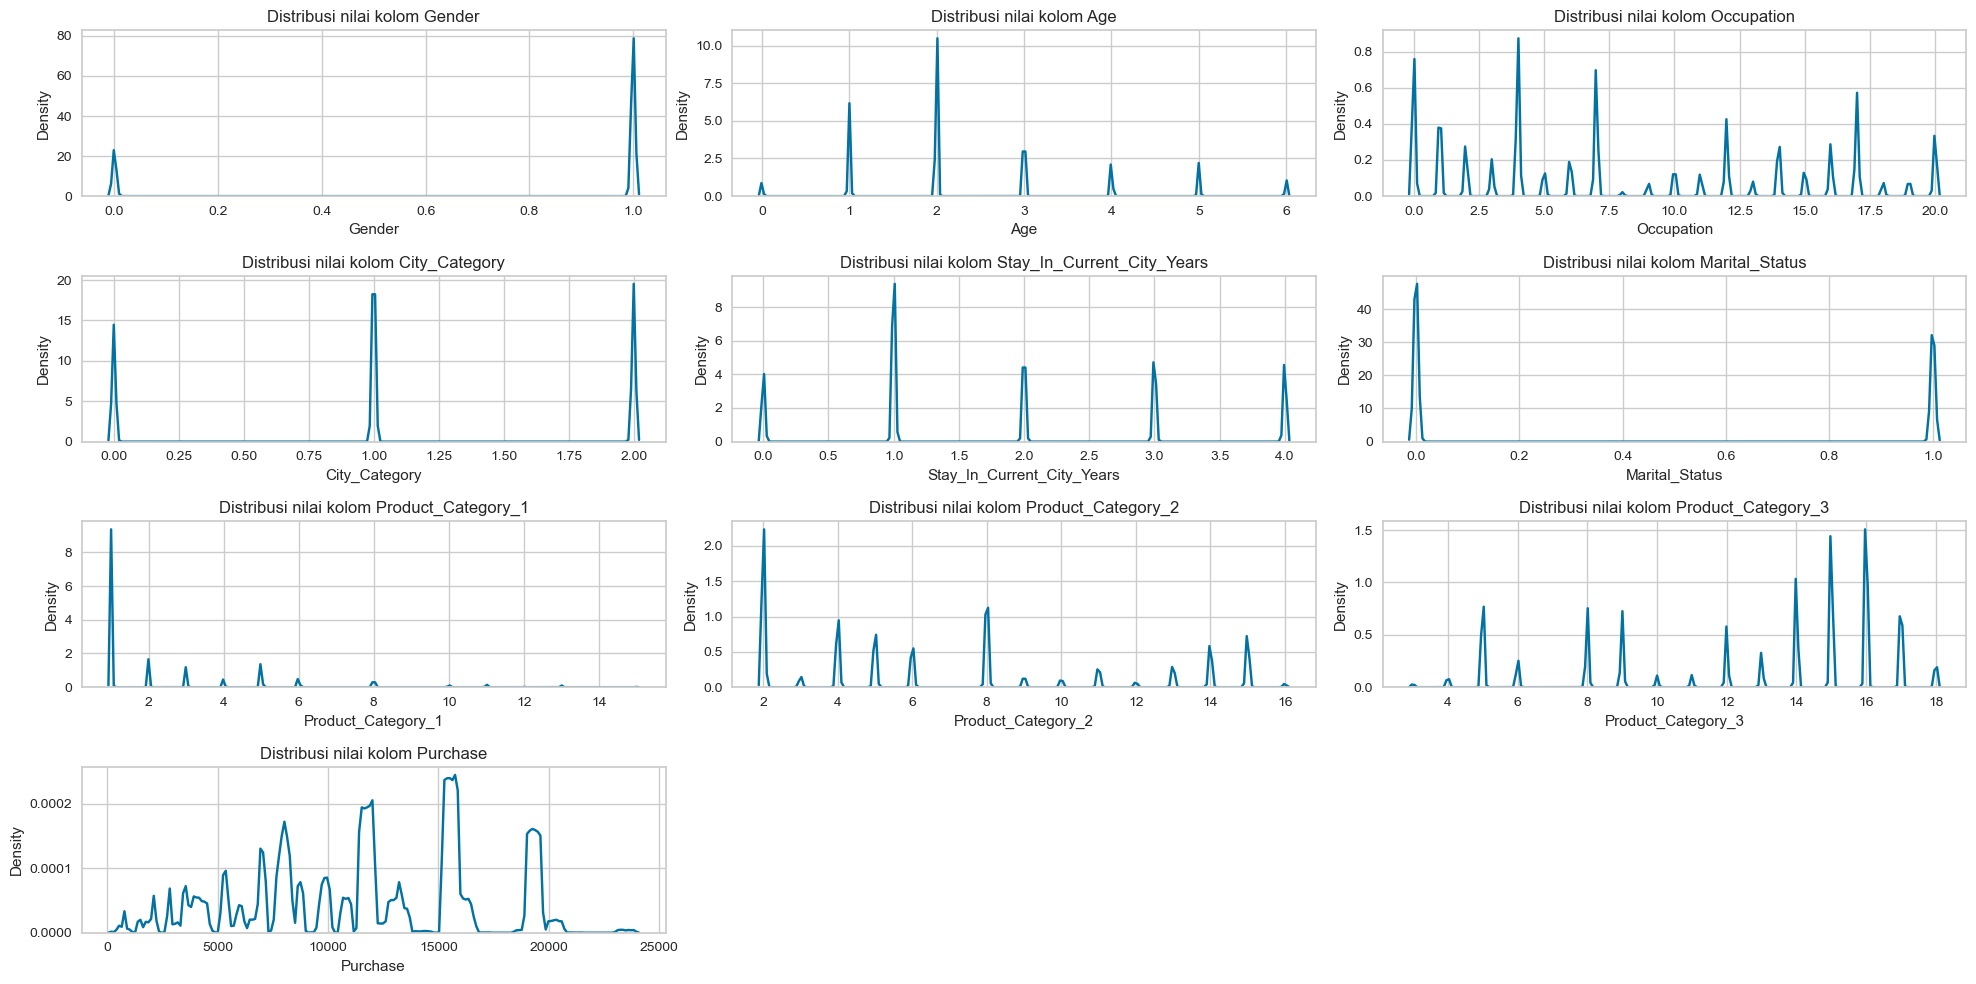

In [43]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# num_cols = 3
# num_rows = math.ceil(len(numerical_columns) / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# for i, column in enumerate(numerical_columns):
#     row = i // num_cols
#     col = i % num_cols
#     sns.kdeplot(data=data, x=column, hue="Region", 
#                 fill=True, alpha=.2, palette="YlOrRd", 
#                 common_norm=False, ax=axes[row, col],
#                 warn_singular=False)\
#         .set_title(column)

# for i in range(len(numerical_columns), num_rows * num_cols):
#     row = i // num_cols
#     col = i % num_cols
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
sns.pairplot(data, diag_kind="kde")

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

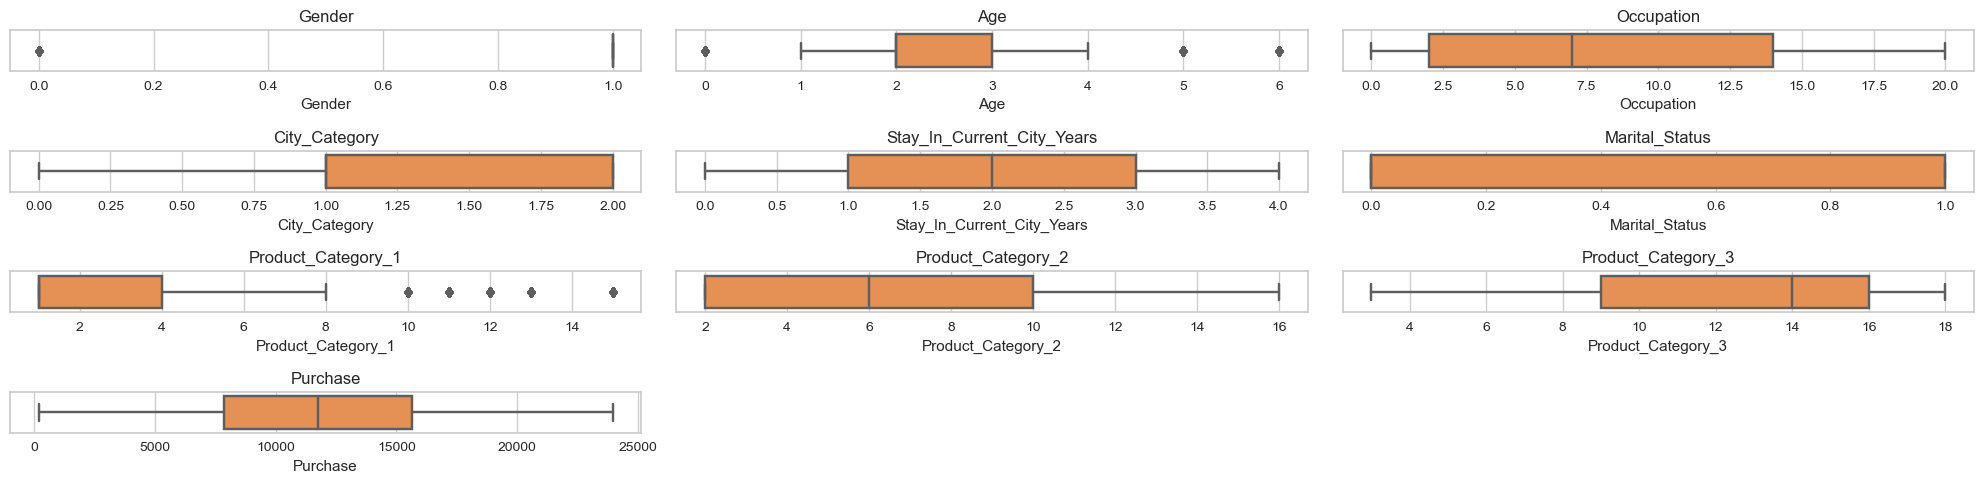

In [45]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

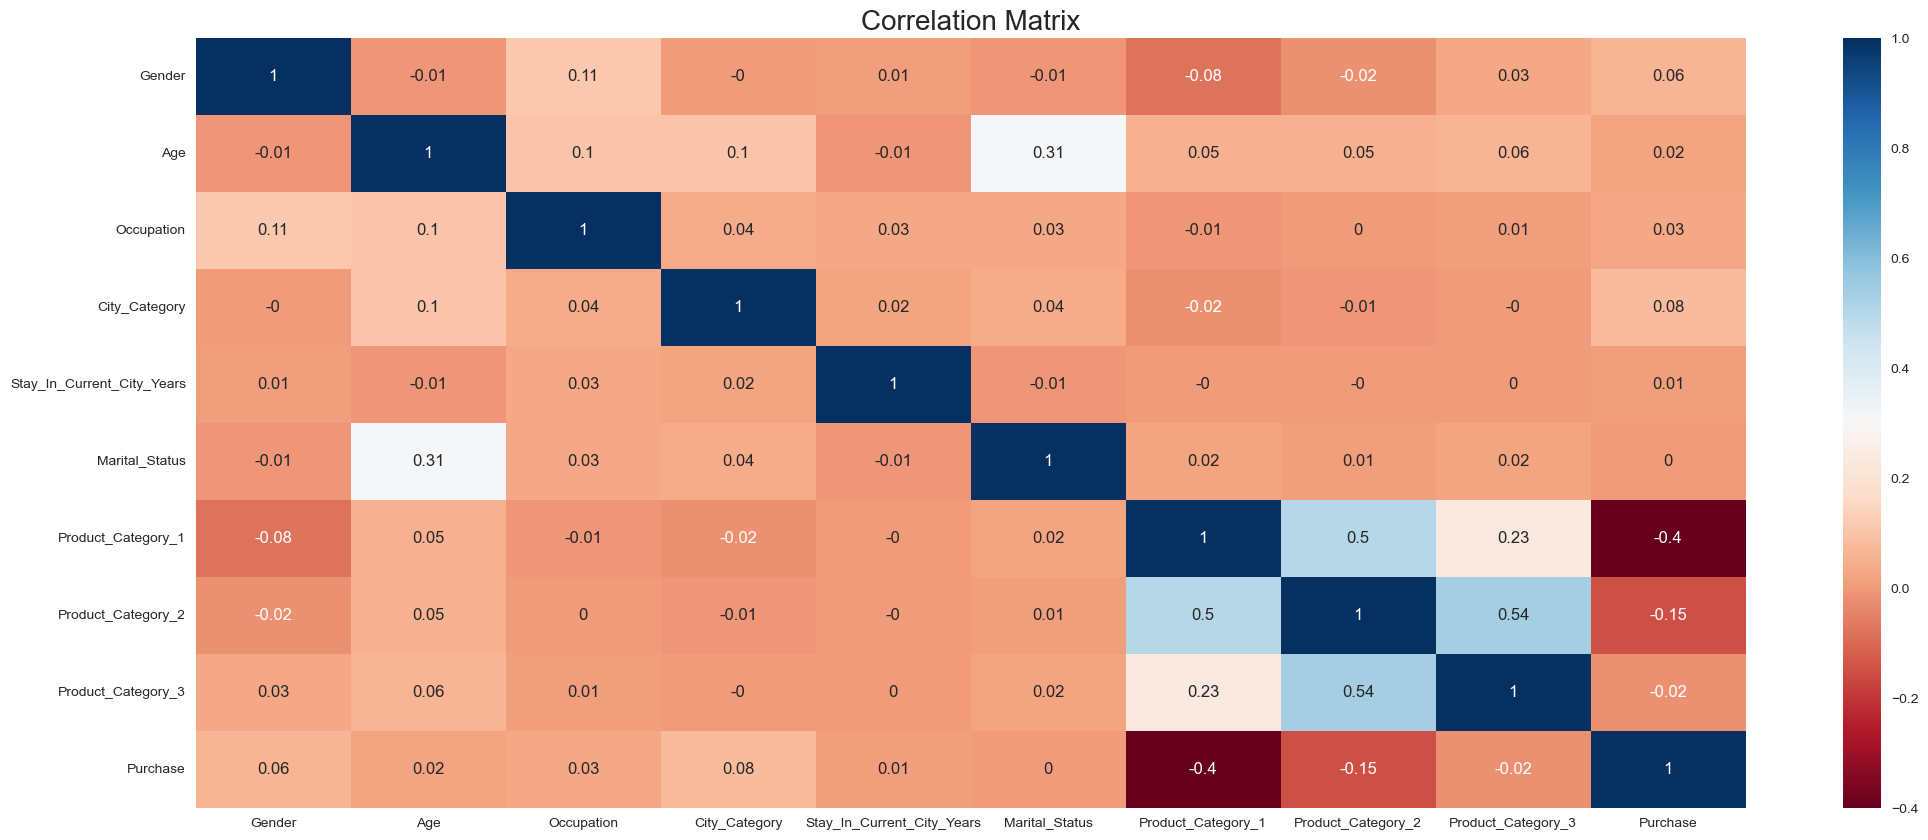

In [46]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [9]:
X = data.drop(columns=['Purchase'])
Y = data['Purchase']

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(116960, 9) (116960,)
(32989, 9) (32989,)
(16661, 9) (16661,)


# 5. Neural Network Algoritms

In [50]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              10240     
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 289,153
Trainable params: 289,153
Non-trainable params: 0
_________________________________________________________________


In [52]:
num_epoch = 100
batch_size = 64

history = model.fit(X_train, y_train, verbose=1,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/100
1828/1828 [==============================] - 6s 3ms/step - loss: 19622258.0000 - mse: 19622226.0000 - val_loss: 19975772.0000 - val_mse: 19975740.0000
Epoch 2/100
1828/1828 [==============================] - 6s 3ms/step - loss: 19600086.0000 - mse: 19600040.0000 - val_loss: 19931572.0000 - val_mse: 19931534.0000
Epoch 3/100
1828/1828 [==============================] - 5s 3ms/step - loss: 19574750.0000 - mse: 19574712.0000 - val_loss: 19912626.0000 - val_mse: 19912592.0000
Epoch 4/100
1828/1828 [==============================] - 6s 3ms/step - loss: 19554376.0000 - mse: 19554326.0000 - val_loss: 19884476.0000 - val_mse: 19884438.0000
Epoch 5/100
1828/1828 [==============================] - 6s 3ms/step - loss: 19524428.0000 - mse: 19524386.0000 - val_loss: 19862112.0000 - val_mse: 19862072.0000
Epoch 6/100
1828/1828 [==============================] - 5s 3ms/step - loss: 19492744.0000 - mse: 19492700.0000 - val_loss: 19832636.0000 - val_mse: 19832594.0000
Epoch 7/100
1828/1828 

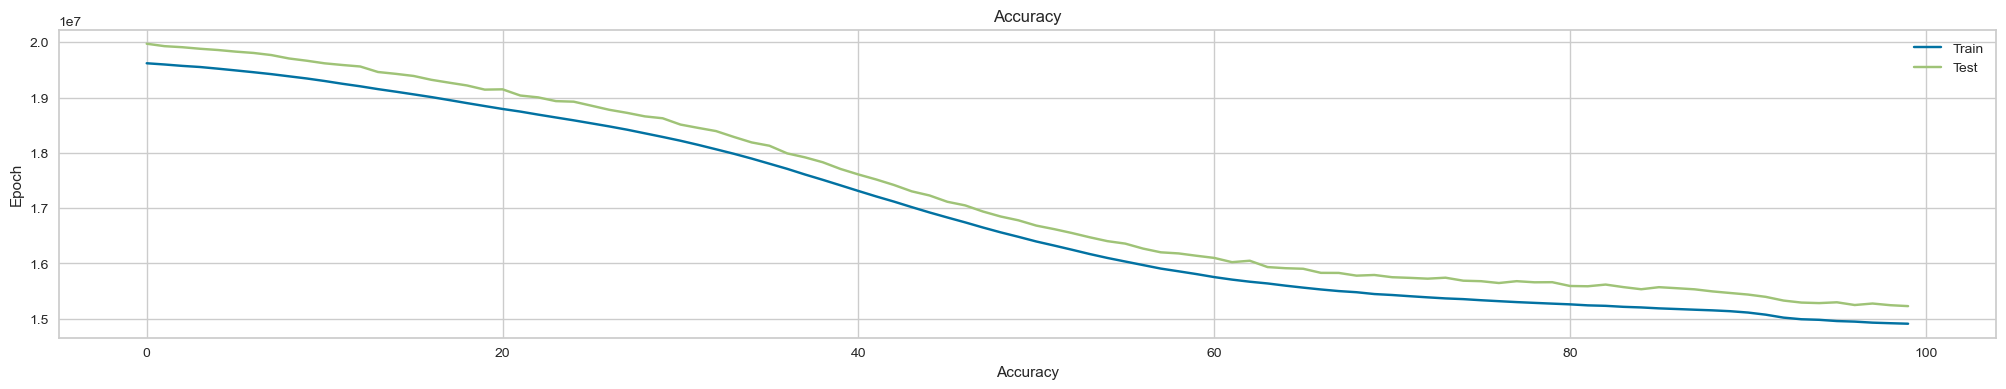

In [53]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [54]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

R Squared Error    : 0.41
Mean Squared Error : 15089323.44
Mean Absolute Error: 3028.34


In [56]:
train_predictions = model.predict(X_test, verbose=0).astype(int).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


        Train Predictions  Actuals   Diff
71107                6142     5283    859
378129              14646     3976  10670
349003              13084    18968   5884
394502               6441     7194    753
77515               14760    15288    528
3028.366334232623 / 99902777
17029


In [ ]:
data_x = data.drop(columns=['price'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = (model.predict(data_x, verbose=0)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [67]:
import optuna

def objective(trial, data = data):
    
    X = data.drop(columns=['Purchase'])
    Y = data['Purchase']

    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    scaler = PowerTransformer(method='yeo-johnson', standardize=True)
    X = scaler.fit_transform(X)

    X_train,X_test,y_train,y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
    
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,2000,3000,4000]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds_valid, squared=False)
    return rmse

    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params

[I 2023-05-04 20:23:00,573] A new study created in memory with name: no-name-f5fe31ab-7f32-4fb2-aab0-8552a2191b51


In [63]:
best_params = {'lambda': 0.0006657878677616344, 
               'alpha': 0.04329935360636625, 
               'colsample_bytree': 1.0, 
               'subsample': 0.5, 
               'learning_rate': 0.018, 
               'n_estimators': 2000, 
               'max_depth': 11, 
               'random_state': 24, 
               'min_child_weight': 41}

adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
model = XGBRegressor(**best_params)
# XGB = XGBRegressor()
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)
linear = LinearRegression()

# model = StackingRegressor([
#     # ('extraTrees', extraTrees),
#     # ('histGradient', histGradient),
#     ('adaboost', adaboost),
#     # ('bagging', bagging),
#     # ('randomforest', randomForest),
#     # ('XGB', XGB),
#     # ('decisionTree', decisionTree),
#     # ('linear', linear),
#     # ('gradient', gradient),
#     # ('knn', knn),
# ])

In [64]:
model.fit(X_train, y_train)

XGBRegressor(alpha=0.04329935360636625, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0006657878677616344,
             learning_rate=0.018, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
             max_leaves=None, min_child_weight=41, missing=nan,
             monotone_constraints=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, ...)

In [65]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')
print("Validationg Score  :",round((model.score(X_val, y_val)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 63.16 %
Test Score         : 52.08 %
Validationg Score  : 51.71 %
R Squared Error    : 0.52
Mean Squared Error : 12350033.62
Mean Absolute Error: 2704.77


In [66]:
train_predictions = (model.predict(X_test)).astype(int).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test.astype(int)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


        Train Predictions  Actuals  Diff
71107                5999     5283   716
378129              11561     3976  7585
349003              13725    18968  5243
394502               6686     7194   508
77515               13415    15288  1873
2704.797538573464 / 89228566
16288


In [60]:
data_x = data.drop(columns=['Name', 'Overall'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = np.rint(model.predict(data_x)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

,Name,Age,Nationality,Overall,Potential,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,GKReflexes,Defending,General,Mental,Passing,Mobility,Power,Shooting,Rating,Overall Prediction
0,L. Messi,31,6,94,94,212,0,5.0,4.0,4.0,...,8.0,29,89,71,87,91,74,88,94,94
1,Cristiano Ronaldo,33,123,94,94,326,1,5.0,4.0,5.0,...,11.0,27,88,73,81,91,83,88,94,94
2,Neymar Jr,26,20,92,93,436,1,5.0,5.0,5.0,...,11.0,28,85,72,80,94,69,84,92,92
3,De Gea,27,139,91,93,375,1,4.0,3.0,1.0,...,94.0,16,26,43,39,66,54,21,92,89
4,K. De Bruyne,27,13,91,92,374,1,4.0,5.0,4.0,...,13.0,59,79,81,92,81,76,85,92,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,46,47,65,165,1,1.0,2.0,2.0,...,9.0,45,39,46,43,55,54,37,56,47
18203,N. Christoffersson,19,144,47,63,588,1,1.0,2.0,2.0,...,12.0,19,41,37,30,40,52,39,55,47
18204,B. Worman,16,46,47,67,122,1,1.0,3.0,2.0,...,13.0,19,43,36,30,59,51,42,57,47
18205,D. Walker-Rice,17,46,47,66,587,1,1.0,3.0,2.0,...,9.0,24,44,38,39,48,50,45,56,48


### 6.2. Pycarets

In [37]:
s = RegressionExperiment()
s.setup(data, target = 'Item_Outlet_Sales', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Item_Outlet_Sales
2,Target type,Regression
3,Original data shape,"(1705, 37)"
4,Transformed data shape,"(1705, 37)"
5,Transformed train set shape,"(1193, 37)"
6,Transformed test set shape,"(512, 37)"
7,Numeric features,36
8,Preprocess,True
9,Imputation type,simple


In [38]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:30:58
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


HuberRegressor()


In [ ]:
s.evaluate_model(best)

In [39]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,590.1542,797415.2204,892.9811,0.7127,0.4866,0.4199


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Overall Prediction,Item_Outlet_Sales,prediction_label
1134,12.150000,0.021757,165.018402,1999,0,1,0,0,0,0,...,1,0,0,0,1,0,0,2658,3302.367920,2684.177348
249,9.800000,0.141406,50.000801,2007,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1643,506.007996,1572.491272
1143,6.135000,0.079327,152.836594,1997,0,0,1,0,0,1,...,1,0,0,0,1,0,0,2648,2871.595459,2468.206772
809,12.911574,0.124300,73.469597,1985,0,1,0,0,0,0,...,1,0,0,1,0,0,0,313,298.278412,381.094023
657,6.920000,0.038447,63.585201,2004,0,1,0,0,0,0,...,0,1,0,0,1,0,0,883,751.022400,950.244089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,17.200001,0.025162,145.941803,2004,0,0,1,0,0,0,...,0,1,0,0,1,0,0,2694,1765.701660,2689.931096
1688,9.800000,0.026895,128.401993,2002,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1637,2403.538086,1719.376834
1612,16.000000,0.173463,157.697205,2009,0,0,1,0,0,0,...,0,0,1,0,0,1,0,2359,2960.146729,2184.149560
954,9.800000,0.013830,45.306000,1987,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1388,1304.968018,1318.843237
